### Development of a score based on the gaussian heatmaps 
This can be used to generate the 'ground truth' score of the heatmaps produced from the Contextual layer , which will be compared with the score produced from the FCN heatmaps layer. 

- First we generate the heatmaps, and also visually cehck them. 
- the we pass the heatmaps to the routine that prodcues the scores 


In [3]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
import tensorflow as tf
import keras.backend as KB
import numpy as np
from mrcnn.datagen     import data_generator, load_image_gt
from mrcnn.callbacks   import get_layer_output_1,get_layer_output_2
from mrcnn.utils       import mask_string
import mrcnn.visualize as visualize
from mrcnn.prep_notebook import prep_dev_notebook

model, dataset_train, train_generator, config = prep_dev_notebook(init_with = 'last', FCN_layers = False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
 Initialize config object - super
(56, 56)
 COCO Model Path       :  E:\Models\mask_rcnn_coco.h5
 Checkpoint folder Path:  E:\Models\mrcnn_logs
E:\Models
E:\Models\mask_rcnn_coco.h5
E:\Models\resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
E:\Models\mrcnn_logs
>>> Initialize model WITHOUT MASKING LAYERS!!!!
    set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180516T1611\mask_rcnn_shapes_{epoch:04d}.h5
    set_log_dir: self.epoch set to 0 

>>> Resnet Graph 
     Input_image shape : (?, 128, 128, 3)
     After ZeroPadding2D  : (?, 134, 134, 3) (?, 134, 134, 3)
     After Conv2D padding : (?, 64, 64, 64) (?, 64, 64, 64)
     After BatchNorm      : (?, 64, 64, 64) (?, 64, 64, 64)
     After MaxPooling2D   : (?, 32, 32, 64) (?, 32, 32, 64)

>>> Feature Pyramid Network (FPN) Graph 
     FPN P2 shape : (None, 32, 32, 256)
     FPN P3 shape : (None, 16, 16, 256)
     FPN P4 shape : 

    gaussian_bbox_scores final shape   :  (?, ?, ?, ?)
    complete

 
  > NEW build_heatmap() for  ['gt_heatmap']
    orignal in_tensor shape :  (3, 4, 100, 6)
    num of bboxes per class is :  100
    pt2_sum shape  (3, 4, 100)
    dense shape  (?, 6)
    X/Y shapes : (128, 128) (128, 128)
    Ones:     (?, 1, 1)
    ones_exp * X (?, 1, 1) * (128, 128) =  (?, 128, 128)
    ones_exp * Y (?, 1, 1) * (128, 128) =  (?, 128, 128)
    before transpse  (?, 128, 128, 2)
    after transpose  (128, 128, ?, 2)
     Prob_grid shape before tanspose:  (128, 128, ?)
     Prob_grid shape after tanspose:  (?, 128, 128)
    >> input to MVN.PROB: pos_grid (meshgrid) shape:  (128, 128, ?, 2)
    << output probabilities shape: (?, 128, 128)

    Scatter out the probability distributions based on class --------------
    pt2_ind shape   :  (?, 3)
    prob_grid shape :  (?, 128, 128)
    gauss_scatt     :  (3, 4, 100, 128, 128)

    Reduce sum based on class ---------------------------------------------
  

Image id:  40
Image meta [ 40 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 1]


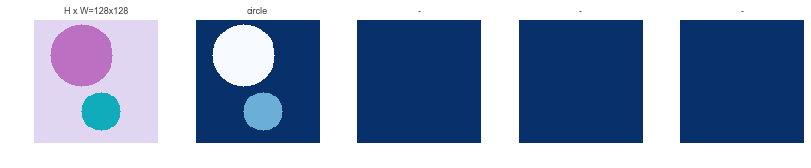

Image id:  122
Image meta [122 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [1 2 2]


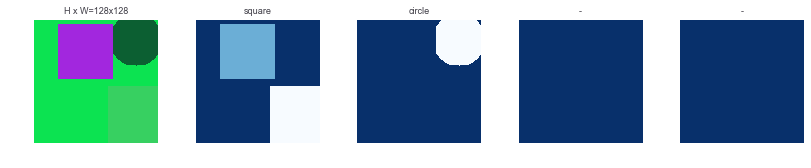

Image id:  54
Image meta [ 54 128 128   3   0   0 128 128   1   1   1   1]
Classes (1: circle, 2: square, 3: triangle ):  [3 2]


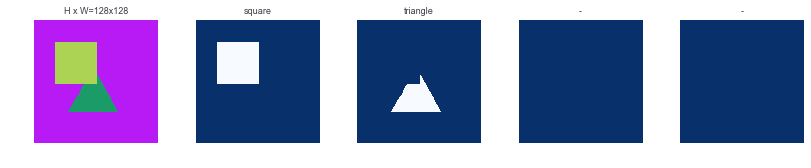

In [14]:
train_batch_x, train_batch_y = next(train_generator)

# train_batch_x, train_batch_y = next(train_generator)
imgmeta_idx = model.keras_model.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

for img_idx in range(config.BATCH_SIZE):
    image_id = img_meta[img_idx,0]
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print('Image id: ',image_id)
    print('Image meta', img_meta[img_idx])
    print('Classes (1: circle, 2: square, 3: triangle ): ',class_ids)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [15]:
print('\n Inputs: ') 
for i, out in enumerate(model.keras_model.inputs):
    print(i , '    ', out)

print('\n Outputs: ') 
for i, out in enumerate(model.keras_model.outputs):
    print(i , '    ', out)



 Inputs: 
0      Tensor("input_image:0", shape=(?, 128, 128, 3), dtype=float32)
1      Tensor("input_image_meta:0", shape=(?, ?), dtype=float32)
2      Tensor("input_rpn_match:0", shape=(?, ?, 1), dtype=int32)
3      Tensor("input_rpn_bbox:0", shape=(?, ?, 4), dtype=float32)
4      Tensor("input_gt_class_ids:0", shape=(?, ?), dtype=int32)
5      Tensor("input_gt_boxes:0", shape=(?, ?, 4), dtype=float32)
6      Tensor("input_gt_masks:0", shape=(?, 56, 56, ?), dtype=bool)

 Outputs: 
0      Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32)
1      Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32)
2      Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32)
3      Tensor("rpn_proposal_rois/packed_2:0", shape=(3, ?, ?), dtype=float32)
4      Tensor("proposal_targets/output_rois:0", shape=(3, ?, ?), dtype=float32)
5      Tensor("proposal_targets/target_class_ids:0", shape=(3, ?), dtype=int32)
6      Tensor("proposal_targets/target_bbox_deltas:0", shape=(3,

In [16]:

# model_output = get_layer_output_2(model.keras_model, train_batch_x, 1)
model_output = get_layer_output_1(model.keras_model, train_batch_x, [1,2,3,4, 15,17,19], 1)
print(len(model_output))

/* Inputs */
Input  0:  (input_image:0                           ) 	  Input shape: (3, 128, 128, 3)
Input  1:  (input_image_meta:0                      ) 	  Input shape: (3, 12)
Input  2:  (input_rpn_match:0                       ) 	  Input shape: (3, 4092, 1)
Input  3:  (input_rpn_bbox:0                        ) 	  Input shape: (3, 256, 4)
Input  4:  (input_gt_class_ids:0                    ) 	  Input shape: (3, 100)
Input  5:  (input_gt_boxes:0                        ) 	  Input shape: (3, 100, 4)
Input  6:  (input_gt_masks:0                        ) 	  Input shape: (3, 56, 56, 100)

/* Outputs */
Output  1: (rpn_class/concat:0                      ) 	  Output shape: (3, 4092, 2)
Output  2: (rpn_bbox/concat:0                       ) 	  Output shape: (3, 4092, 4)
Output  3: (rpn_proposal_rois/packed_2:0            ) 	  Output shape: (3, 2000, 4)
Output  4: (proposal_targets/output_rois:0          ) 	  Output shape: (3, 32, 4)
Output 15: (cntxt_layer/pred_heatmap_norm:0         ) 	  Out

In [7]:
input_image      =  train_batch_x[0]
input_image_meta =  train_batch_x[1]
input_rpn_match  =  train_batch_x[2]
input_rpn_bbox   =  train_batch_x[3]
input_gt_class_ids = train_batch_x[4]
input_gt_bboxes    = train_batch_x[5]
input_gt_masks     = train_batch_x[6]
h, w = input_image.shape[0], input_image.shape[1]      #  tf.shape(input_image)[1], tf.shape(input_image)[2]
input_normlzd_gt_bboxes = tf.identity(input_gt_bboxes / [h,w,h,w])

# gt_masks   =  train_batch_x[6]
print(' input_rpn_match    ', input_rpn_match.shape)
print(' input_rpn_bbox     ', input_rpn_bbox.shape)
print(' input_gt_class_ids ', input_gt_class_ids.shape)
print(' input_gt_bboxes    ', input_gt_bboxes.shape)
print(' input_normlzd_gt_bboxes    ', input_normlzd_gt_bboxes.shape)


 input_rpn_match     (3, 4092, 1)
 input_rpn_bbox      (3, 256, 4)
 input_gt_class_ids  (3, 100)
 input_gt_bboxes     (3, 100, 4)
 input_normlzd_gt_bboxes     (3, 100, 4)


In [17]:
print(len(model_output))
# rpn_class_logits   = model_output[0]
rpn_class          = model_output[0]
rpn_bbox           = model_output[1]
rpn_proposal_rois  = model_output[2]
output_rois        = model_output[3]
# target_class_ids   = model_output[5]
# target_bbox_deltas = model_output[6]
# roi_gt_boxes       = model_output[7]
# mrcnn_class_logits = model_output[8]
# mrcnn_class        = model_output[0]
# mrcnn_bbox         = model_output[10]
# rpn_class_loss   = model_output[11]
# rpn_bbox_loss    = model_output[12]
# mrcnn_class_loss = model_output[13]
# mrcnn_bbox_loss  = model_output[14]
# fcn_bbox_loss      = model_output[15]
# pred_hm            = model_output[1]
# gt_hm              = model_output[17]
# pred_hm_norm       = model_output[1]
# gt_hm_norm         = model_output[2]
# pred_hm_scores     = model_output[3]
# gt_hm_scores       = model_output[4]
# pred_tensor        = model_output[5]
# fcn_heatmap        = model_output[23]
# fcn_class_logits   = model_output[24]
# fcn_scores         = model_output[25]
# fcn_bbox_deltas    = model_output[26]
# pred_hm2            = model_output[2]
# pred_hm2_norm       = model_output[3]
# rpn_proposal_rois  = model_output[0]
# output_rois        = model_output[1]
pred_hm_norm       = model_output[4]
# gt_hm_norm         = model_output[3]
pred_hm_scores     = model_output[5]
# gt_hm_scores       = model_output[5]
pred_tensor        = model_output[6]

# print(type(model_output[4]))
# print(type(output_rois))
for i in model_output:
    print( i.shape)

7
(3, 4092, 2)
(3, 4092, 4)
(3, 2000, 4)
(3, 32, 4)
(3, 128, 128, 4)
(3, 4, 32, 8)
(3, 4, 32, 6)


### Proposal Layer

In [ ]:
model.config.display()

In [18]:
import mrcnn.utils as utils
sess = KB.get_session()


In [ ]:
def apply_box_deltas_graph(boxes, deltas):
    """
    Applies the given deltas to the given boxes.

    x,y,w,h : Bounding Box coordinates, width, and height

    Boxes:  is the (y1, x1, y2, x2) of the anchor boxes
    deltas: [dy, dx, log(dh), log(dw)] 
            is the predicted bounding box returned from the RPN layer (in test phase)
            These are considered the targets or ground truth 
    Refer to Bounding Box Regression - R-CNN paper 
    Regression targets are calculated as follows:   
      tx = (GTx - PRx)/PRw       ty = (Gy - Py)/Ph
      th = log(Gw/Pw)         tw = log(Gh/Ph)
    ---------------------------------------------------------------------------------            
    
    boxes:  [N, 4] where each row is [y1, x1, y2, x2]
    deltas: [N, 4] where each row is [dy, dx, log(dh), log(dw)]
    """
    # Convert to y, x, h, w
    height   = boxes[:, 2] - boxes[:, 0]
    width    = boxes[:, 3] - boxes[:, 1]
    center_y = boxes[:, 0] + 0.5 * height
    center_x = boxes[:, 1] + 0.5 * width
    
    # Apply deltas
    center_y += deltas[:, 0] * height
    center_x += deltas[:, 1] * width
    height   *= tf.exp(deltas[:, 2])
    width    *= tf.exp(deltas[:, 3])
    
    # Convert back to y1, x1, y2, x2
    y1 = center_y - 0.5 * height
    x1 = center_x - 0.5 * width
    y2 = y1 + height
    x2 = x1 + width
    result = tf.stack([y1, x1, y2, x2], axis=1, name="apply_box_deltas_out")
    return result


def clip_boxes_graph(boxes, window):
    """
    clip refined anchor boxes such that they remain within the dimensions of the image 
    boxes:  [N, 4] each row is y1, x1, y2, x2
    window: [4] in the form y1, x1, y2, x2 
    """
    # Split corners
    wy1, wx1, wy2, wx2 = tf.split(window, 4)   #  0, 0 , 128,128
    y1 , x1 , y2 , x2  = tf.split(boxes, 4, axis=1)
    
    # Clip
    y1 = tf.maximum(tf.minimum(y1, wy2), wy1)   # ensure  wy1 <= y1 <= wy2
    x1 = tf.maximum(tf.minimum(x1, wx2), wx1)
    y2 = tf.maximum(tf.minimum(y2, wy2), wy1)
    x2 = tf.maximum(tf.minimum(x2, wx2), wx1)
    clipped = tf.concat([y1, x1, y2, x2], axis=1, name="clipped_boxes")
    return clipped

def suppress_small_boxes_graph(boxes, scores, area_threshold ):
    """
    supress boxes with area less than area_threshold
    boxes:  [N, 4] each row is y1, x1, y2, x2
    
    """
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    selected_idxs   = tf.where(tf.greater_equal(bx_area, area_threshold))
    selected_boxes  = tf.gather_nd(boxes, selected_idxs)
    selected_scores = tf.gather_nd(scores, selected_idxs)
    padding   = tf.maximum(tf.shape(boxes)[0] - tf.shape(selected_boxes)[0], 0)

#     print(' box area       : ', bx_area.shape)    
#     print(' selected_idxs  : ', tf.shape(selected_idxs).eval())
#     print(' selected scores: ', tf.shape(selected_scores).eval())
#     print(' Req padding    : ', padding.eval())
    
    selected_boxes  = tf.pad(selected_boxes, [(0, padding), (0, 0)])    
    selected_scores = tf.pad(selected_scores, [(0, padding)])    
    return selected_boxes, selected_scores

def nms(normalized_boxes, scores):
    proposal_count = model.config.POST_NMS_ROIS_TRAINING
    rms_threshold  = model.config.RPN_NMS_THRESHOLD
    indices = tf.image.non_max_suppression(normalized_boxes, 
                                           scores, 
                                           proposal_count,
                                           nms_threshold, 
                                           name="rpn_non_max_suppression")

    proposals = tf.gather(normalized_boxes, indices)
    # Pad if needed
    padding   = tf.maximum(proposal_count - tf.shape(proposals)[0], 0)
    proposals = tf.pad(proposals, [(0, padding), (0, 0)])
    return proposals

In [ ]:
with sess.as_default():
    
    
    scores = rpn_class[:, :, 1]
    print(scores.shape)
    deltas = rpn_bbox
    print('deltas shape', deltas.shape)
    deltas = deltas * np.reshape(model.config.RPN_BBOX_STD_DEV, [1, 1, 4])
    print('deltas shape', deltas.shape)
    anchors = model.anchors
    print('model.anchors.shape', model.anchors.shape)
    pre_nms_limit = min(6000, model.anchors.shape[0])
    print('pre nms limit', pre_nms_limit)

    ix = tf.nn.top_k(scores, pre_nms_limit, sorted=True,name="top_anchors").indices

    ## gather top scores (pre_nms_limit = min(6000, # anchors) number of scores from scores)        
    scores  = utils.batch_slice([scores, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU) 
    print(' selected scores: ',scores.shape)

    ## get corrsponding deltas generated by RPN
    deltas  = utils.batch_slice([deltas, ix], lambda x, y: tf.gather(x, y), model.config.IMAGES_PER_GPU)
    print(' selected deltas: ',deltas.shape)
    anchors = utils.batch_slice(         ix , lambda x   : tf.gather(anchors, x), model.config.IMAGES_PER_GPU, names=["pre_nms_anchors"])
    print(' selected anchors: ',anchors.shape)
    boxes = utils.batch_slice([anchors, deltas],
                              lambda x, y: apply_box_deltas_graph(x, y),model.config.IMAGES_PER_GPU,
                              names=["refined_anchors"])
    print(' delta applied boxes :', boxes.shape)

    # Clip to image boundaries. [batch, N, (y1, x1, y2, x2)]
    height, width = model.config.IMAGE_SHAPE[:2]
    window = np.array([0, 0, height, width]).astype(np.float64)
    print(' window is ', window)
    clipped_boxes  = utils.batch_slice(boxes, 
                                   lambda x: clip_boxes_graph(x, window), model.config.IMAGES_PER_GPU,
                                   names=["refined_anchors_clipped"])

    print(' clipped boxes :', clipped_boxes.shape)
    
    ## Suppress proposal boxes (and  corresponding score) if the area is less than ROI_AREA_THRESHOLD
    roi_area_threshold = 2
    mod_boxes, mod_scores = utils.batch_slice([clipped_boxes,scores], 
                            lambda x, y: suppress_small_boxes_graph(x, y, roi_area_threshold), model.config.IMAGES_PER_GPU,
                            names=["mod_boxes", "mod_scores"])  
    print(' mod boxes :', tf.shape(mod_boxes).eval())
    print(' mod_scores:', tf.shape(mod_scores).eval())   
    
    normalized_boxes = tf.cast(mod_boxes / np.array([[height, width, height, width]]), tf.float32)
    print(' normalized boxes:', normalized_boxes.shape)

    proposals = utils.batch_slice([normalized_boxes, mod_scores], nms, model.config.IMAGES_PER_GPU)
    print('     Output: Prposals shape : ', proposals.shape, tf.shape(proposals).eval())
    

####  Analyze proposals results 

In [19]:
sess = KB.get_session()
with sess.as_default():
    proposals = tf.identity(rpn_proposal_rois)  # <--- this uses the results from the model 

    bx_area = (proposals[...,2]-proposals[...,0])*(proposals[...,3]-proposals[...,1])
    print(' proposals :', tf.shape(proposals).eval())
    print(' box area : ', tf.shape(bx_area).eval())
    
    selected_idxs = tf.where(tf.less_equal(bx_area, (2/(128*128))) )
    print('selected bx:', tf.shape(selected_idxs).eval())
    
    print(selected_idxs.eval())
    selected_area      = tf.gather_nd(bx_area  , selected_idxs)
    selected_proposals = tf.gather_nd(proposals, selected_idxs)
    print('selected proposals shape', tf.shape(selected_proposals).eval())
    print(selected_proposals[0:30].eval())
    print('selected area shape', tf.shape(selected_area).eval())
    print(selected_area[0:30].eval())
    

 proposals : [   3 2000    4]
 box area :  [   3 2000]
selected bx: [1383    2]
[[   0 1242]
 [   0 1243]
 [   0 1244]
 ...
 [   2 1997]
 [   2 1998]
 [   2 1999]]
selected proposals shape [1383    4]
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
selected area shape [1383]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


####  Analyze bounding box areas 

In [ ]:
with sess.as_default():
    print(' boxes :', boxes.shape)
    for i in [0,10,17,25,26,34,39]:
        print(i, ' non-clipped ', boxes[0, i].eval())
    bx_area = (boxes[...,2]-boxes[...,0])*(boxes[...,3]-boxes[...,1])
    print(' box area : ', bx_area.shape)
    np.set_printoptions(linewidth=130,precision=4,threshold=4096)
    print(bx_area[:, :20].eval(session=sess))
    small_idxs = tf.where(bx_area < 1)
    print('small bx:', tf.shape(small_idxs).eval())
    print(small_idxs[0:10].eval())
    small_area  = tf.gather_nd(bx_area, small_idxs)
    small_boxes = tf.gather_nd(boxes, small_idxs)
    print('small boxes shape', tf.shape(small_boxes).eval())
    print(small_boxes[0:30].eval())
    print('small area shape', tf.shape(small_area).eval())
    print(small_area[0:30].eval())
    

#### Apply non-maximal Supression for 1 image

In [ ]:
proposal_count = model.config.POST_NMS_ROIS_TRAINING
nms_threshold  = model.config.RPN_NMS_THRESHOLD
img = 1
with sess.as_default():

    print('image', img)
    indices = tf.image.non_max_suppression(normalized_boxes[img], 
                                       scores[img], 
                                       proposal_count,
                                       nms_threshold, 
                                       name="rpn_non_max_suppression")
    print(' nms indices shape: ', tf.shape(indices).eval())
#     print( indices[751].eval())
    proposals = tf.gather(normalized_boxes[0], indices)
    print(' Prposals shape:', tf.shape(proposals).eval())
    # Pad if needed
    padding   = tf.maximum(proposal_count - tf.shape(proposals)[0], 0)
    print(' Required padding ', padding.eval())
    proposals = tf.pad(proposals, [(0, padding), (0, 0)])
    print(' Prposals shape after padding :', tf.shape(proposals).eval())
    
    bx_area = (proposals[...,2]-proposals[...,0])*(proposals[...,3]-proposals[...,1])
    print(' box area : ', tf.shape(bx_area).eval())
    
    np.set_printoptions(linewidth=130,precision=4,threshold=4096)
    print(bx_area[:20].eval())
    

In [ ]:
with sess.as_default():
    print('     Scores : ' , scores.shape)
    print('     Deltas : ' , deltas.shape)
    print('     Anchors: ' , anchors.shape)
    print('     Boxes shape / type after processing: ', boxes.shape)
#     print('Anchors: \n',anchors[0,-20:].eval())
#     print('Deltas: \n',deltas[0,-20:].eval())
    print('Boxes: \n',boxes[1,-20:].eval())
    print('Clipped Boxes: \n',clipped_boxes[1,-20:].eval())

#### Analyze Clipped Boxes

In [ ]:
np.set_printoptions(linewidth=130,precision=4,threshold=4096)

with sess.as_default():
    print(' clipped boxes :', clipped_boxes.shape)
#     for i in [0,10,17,25,26,34,39]:
#         print(i, ' non-clipped ', boxes[0, i].eval())
#         print(i, ' clipped     ', clipped_boxes[0, i].eval())

    clp_bx_area = (clipped_boxes[...,2]-clipped_boxes[...,0])*(clipped_boxes[...,3]-clipped_boxes[...,1])
    print(' clipped box area shape: ', clp_bx_area.shape)
    clp_bx_shp = tf.shape(clp_bx_area).eval()
    ttl_proposals = clp_bx_shp[0]*clp_bx_shp[1]
    
    ## --- print ratios of proposals that are dropped due to suppressing small roi boxes
#     for min_area in range(20):
#         clp_selected_idxs = tf.where(clp_bx_area >= min_area)
#         selected_proposals = tf.shape(clp_selected_idxs).eval()[0]
#         print(' min area lmt : ', min_area, ' clp_selected_idxs:', selected_proposals, ' Ratio:', 1 - (selected_proposals/ttl_proposals))

    clp_selected_idxs = tf.where(clp_bx_area >= min_area)
    print(clp_selected_idxs[0:10].eval())
    
#     non_clp_area  = tf.gather_nd(bx_area, clp_selected_idxs)
#     non_clp_boxes = tf.gather_nd(boxes, clp_selected_idxs) 

    clp_selected_area  = tf.gather_nd(clp_bx_area, clp_selected_idxs)
    clp_selected_boxes = tf.gather_nd(clipped_boxes, clp_selected_idxs)

    print('clipped selected boxes shape', tf.shape(clp_selected_boxes).eval())
#     print(clp_selected_boxes[0:30].eval())
    print('clipped selected area shape ', tf.shape(clp_selected_area).eval())
#     print(clp_selected_area[0:30].eval())


###  Run detection target layer 

In [ ]:
import mrcnn.utils  as utils
from mrcnn.detect_tgt_layer import overlaps_graph
# proposals    = KB.identity(rpn_proposal_rois)[0]
# gt_class_ids = KB.identity(input_gt_class_ids)[0]
# gt_boxes     = KB.identity(input_normlzd_gt_boxes)[0]
# gt_masks     = KB.identity(input_gt_masks)[0]

# proposals    = rpn_proposal_rois[1]
# gt_class_ids = input_gt_class_ids[1]
# gt_boxes     = input_normlzd_gt_boxes[1]
# gt_masks     = input_gt_masks[1]
# config       = model.config

### def `dev_detection_targets_graph`

In [ ]:
def dev_detection_targets_graph(proposals, gt_class_ids, gt_boxes, gt_masks, config):


    print('>>> detection_targets_graph ')
    print('     propsals.shape        :',  proposals.shape, proposals.get_shape(), KB.int_shape(proposals) )
    print('     gt_boxes.shape        :',  gt_boxes.shape ,    KB.int_shape(gt_boxes)   )
    print('     gt_class_ids.shape    :',  gt_class_ids.shape, KB.int_shape(gt_class_ids))
    print('     gt_masks.shape        :',  gt_masks.shape ,    KB.int_shape(gt_masks)   )

    proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
    gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
    gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
    gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

    # print(tf.shape(proposals).eval())
    # print(non_zeros.eval())
    # print('gt_boxes :', tf.shape(gt_boxes).eval())

    ###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

    crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
    non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
    crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
    crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
    gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
    gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
    gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)
    # Compute overlaps with crowd boxes [anchors, crowds]
    crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
    crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
    no_crowd_bool   = (crowd_iou_max < 0.001)

    # print('crowd ixs: ', crowd_ix.eval())
    # print('non_crowrd_ixs', non_crowd_ix.eval())
    # print('non crowd bool', no_crowd_bool.eval())

    overlaps        = overlaps_graph(proposals, gt_boxes)
    print('     overlaps.shape :',  tf.shape(overlaps).eval())
    
    roi_iou_max            = tf.reduce_max(overlaps, axis=1)
    print(' RoI/Gt max IoU')
    # print(roi_iou_max.eval())
    positive_roi_bool     = (roi_iou_max >= 0.5)
    all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
    print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    print('Positive IoUs \n', tf.gather(roi_iou_max,all_positive_indices).eval())

    ## current method
    all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
#     print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
#     print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

    ## method - suppress the proposals with 0 IoUs
    # negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
    # negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
    # negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
    # print('Negative indices')
    # print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
    # print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

    ##------------------------------------------------------------------------------------------------------
    ## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
    ##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
    ##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
    ##------------------------------------------------------------------------------------------------------
    # print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
    # print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
    # print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
    # print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

    positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
    negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
    print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
#     print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

    ##------------------------------------------------------------------------------------------------------
    ##  Select positive samples from amongst positive bounding boxes
    ##------------------------------------------------------------------------------------------------------
    ## current method
    positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
    ## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

    ## New:
    positive_indices      = positive_ind_shuffled[:positive_count]
    positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

    ##------------------------------------------------------------------------------------------------------
    ##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
    ##
    ## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
    ## negative count, due to the fact that positive_count is cast to an int. 
    ## for eg. int(32 * 0.333) = int(10.56) = 10. 
    ## 
    ## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
    ## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
    ## some of these will be used to introduce false positives/
    ##------------------------------------------------------------------------------------------------------
    # r = 1.0 / config.ROI_POSITIVE_RATIO
    # print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
    # negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
    # print('Negative Count : ', negative_count.eval())

    # all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
    # all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
    # print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())
    
    ##------------------------------------------------------------------------------------------------------
    ## Here is the alterantive method
    ## Determine Negative count as different between total RoIs per image and number of positives we found
    ## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
    ##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  
    
    ##------------------------------------------------------------------------------------------------------
    all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
    false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

    false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
    false_positive_count  = tf.shape(false_positive_indices)[0]
    
    # print('Positive Count       : ', positive_count.eval())
    # print('All Negative Count   : ', all_negative_count.eval())
    # print('False Positive Count Goal: ', false_positive_count_goal.eval())


    # print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
    # print(false_positive_indices.eval())
    
    negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
    negative_count     = tf.shape(negative_indices)[0]
    # print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
    #       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
    # print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


    ##------------------------------------------------------------------------------------------------------
    ## 5.   Gather selected positive and negative ROIs
    ##------------------------------------------------------------------------------------------------------
    positive_rois      = tf.gather(proposals, positive_indices)
    false_positive_rois= tf.gather(proposals, false_positive_indices)
    negative_rois      = tf.gather(proposals, negative_indices)

    # print(positive_rois.eval())
    # print(false_positive_rois.eval())
    # print(negative_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    # 
    #  Remember: The same class can have multiple gt_bounding boxes. So RoIs assiged to same class could have 
    #            DIFFERENT gt_bboxes (classes can have multple bounding boxes -- like when the same shape 
    #           appears twice in an image)
    #------------------------------------------------------------------------------------------------------
    positive_overlaps     = tf.gather(overlaps, positive_indices)
    roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
    roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
    roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)
    
#     print('Positive indices: \n',positive_indices.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' positive overlaps shape  :  ', sess.run(positive_overlaps, roi_gt_box_assignment))
#     print(tf.reduce_max(positive_overlaps, axis = 1).eval())
#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

    #------------------------------------------------------------------------------------------------------
    ## 7.   Compute bbox delta 
    #  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
    #------------------------------------------------------------------------------------------------------
    deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
    deltas /= config.BBOX_STD_DEV
    # print('deltas')
    # print(deltas.eval())
    # print(' Positive RoIs ')
    # print(positive_rois.eval())

    #------------------------------------------------------------------------------------------------------
    # 6.   Assign GT bbounding boxes and classes to the false positive RoIs
    #
    #  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
    #  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
    #
    #------------------------------------------------------------------------------------------------------
    fp_overlaps          = tf.gather(overlaps, false_positive_indices)
    fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
    fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
    fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
#     print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
    # print(' FP overlaps            \n', fp_overlaps.eval())
    # print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
    # print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
    # print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
    return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
def overlaps_graph(boxes1, boxes2):
    '''
    Computes IoU overlaps between two sets of boxes.in normalized coordinates
    
    boxes1 - proposals :  [batch_size,  proposal_counts, 4 (y1, x1, y2, x2)] <-- Region proposals
    boxes2 - gt_boxes  :  [batch_size, max_gt_instances, 4 (y1, x1, y2, x2)] <-- input_normlzd_gt_boxes
    
    proposal_counts : 1000 or 2000 based on training or inference
    max_gt_instances: 100
    
    returns :
    ---------
    overlaps :          [ proposal_counts, max_gt_instances] 
                        IoU of all proposal box / gt_box pairs
    '''
    # 1. Tile boxes2 and repeat boxes1. This allows us to compare every boxes1 against every boxes2 without loops.
    #    TF doesn't have an equivalent to np.repeat() so simulate it using tf.tile() and tf.reshape.
    
#     print('\t>>> detection_targets_graph - calculate Overlaps_graph')    
#     print('\t     overlaps_graph: shape of boxes1 before reshape: ',tf.shape(boxes1).eval())  # (?,?)
#     print('\t     overlaps_graph: shape of boxes2 before reshape: ',tf.shape(boxes2).eval())  # (?,?)
    
    # tf.expand_dims(boxes1, 1) : makes b1:[1, proposal_count_sz, 4] 
    b1 = tf.reshape(tf.tile(tf.expand_dims(boxes1, 1), [1, 1, tf.shape(boxes2)[0]]), [-1, 4])
    b2 = tf.tile(boxes2, [tf.shape(boxes1)[0], 1])
    
#     print('\t     overlaps_graph: shape of boxes1 after reshape: ',tf.shape(b1).eval())  # (?,4)
#     print('\t     overlaps_graph: shape of boxes2 after reshape: ',tf.shape(b2).eval())  # (?,4)

    # 2. Compute intersections
    b1_y1, b1_x1, b1_y2, b1_x2 = tf.split(b1, 4, axis=1)
    b2_y1, b2_x1, b2_y2, b2_x2 = tf.split(b2, 4, axis=1)
    
#     print('     overlaps_graph: shape of b1_y1 after split: ',tf.shape(b2_y1).eval())  # (?,4)
    y1 = tf.maximum(b1_y1, b2_y1)
    x1 = tf.maximum(b1_x1, b2_x1)
    y2 = tf.minimum(b1_y2, b2_y2)
    x2 = tf.minimum(b1_x2, b2_x2)
    intersection = tf.maximum(x2 - x1, 0) * tf.maximum(y2 - y1, 0)

    # 3. Compute unions
    b1_area = (b1_y2 - b1_y1) * (b1_x2 - b1_x1)
    b2_area = (b2_y2 - b2_y1) * (b2_x2 - b2_x1)
    union = b1_area + b2_area - intersection
    
    # 4. Compute IoU and reshape to [boxes1, boxes2]
    iou = intersection / union
    overlaps = tf.reshape(iou, [tf.shape(boxes1)[0], tf.shape(boxes2)[0]])
#     print('\t     Overlaps_graph(): Shape of output overlaps', tf.shape(overlaps).eval(), overlaps.get_shape())
    return overlaps


### ###  detetct_target_layer -- non function format

#### Take inputs , layer by layer

In [ ]:
try:
    sess.close()
    print('session was deleted ')
except:
    print('Session was not defined ')
    pass
sess = tf.InteractiveSession()


proposals              = tf.identity(rpn_proposal_rois)[0]
gt_class_ids           = tf.identity(input_gt_class_ids)[0]
gt_boxes               = tf.identity(input_normlzd_gt_bboxes)[0]
gt_masks               = tf.identity(input_gt_masks)[0]
print(' normalized gt bboxes : ', input_normlzd_gt_bboxes.shape,gt_boxes.shape)
print(' gt_class_ids         : ', input_gt_class_ids.shape, gt_class_ids.shape)
print(' rpn_proposals        : ', rpn_proposal_rois.shape,proposals.shape)
print(' gt_masks             : ', input_gt_masks.shape, gt_masks.shape)

In [ ]:
print('>>> detection_targets_graph ')
np.set_printoptions(linewidth=130,precision=4, threshold = 4000)

print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('     gt_class_ids.shape    :',  tf.shape(gt_class_ids).eval())
print('     gt_masks.shape        :',  tf.shape(gt_masks).eval() )

proposals, _        = utils.trim_zeros_graph(proposals, name="trim_proposals")
gt_boxes, non_zeros = utils.trim_zeros_graph(gt_boxes , name="trim_gt_boxes")
gt_class_ids        = tf.boolean_mask(gt_class_ids, non_zeros, name="trim_gt_class_ids")
gt_masks            = tf.gather(gt_masks, tf.where(non_zeros)[:, 0], axis=2,name="trim_gt_masks")

print('     propsals.shape        :',  tf.shape(proposals).eval())
print('     gt_boxes.shape        :',  tf.shape(gt_boxes).eval() )
print('     gt_boxes              :\n', gt_boxes.eval())
# print('     rpn proposals         :\n', rpn_proposal_rois)

print(rpn_proposal_rois.shape)
abs_props = rpn_proposal_rois * [128,128,128,128]
area = (abs_props[...,2]-abs_props[...,0])*(abs_props[...,3]-abs_props[...,1])
print(area.shape)
print(np.argsort(area[0]))
# print(abs_props[0,0:100])

In [ ]:
print(abs_props[0,329])

In [ ]:
model.anchors[-500:]

In [ ]:
# print(non_zeros.eval())

###  Separate GT boxes and masks by 'crowd' and 'non-crowd' classifications

crowd_ix        = tf.where(gt_class_ids < 0)[:, 0]
non_crowd_ix    = tf.where(gt_class_ids > 0)[:, 0]
crowd_boxes     = tf.gather(gt_boxes, crowd_ix)
crowd_masks     = tf.gather(gt_masks, crowd_ix, axis=2)
gt_class_ids    = tf.gather(gt_class_ids, non_crowd_ix)
gt_boxes        = tf.gather(gt_boxes, non_crowd_ix)
gt_masks        = tf.gather(gt_masks, non_crowd_ix, axis=2)

# get unique list of classes present in current image
gt_classes_present, _ = tf.unique(gt_class_ids)

# Compute overlaps with crowd boxes [anchors, crowds]
crowd_overlaps  = overlaps_graph(proposals, crowd_boxes)
crowd_iou_max   = tf.reduce_max(crowd_overlaps, axis=1)
no_crowd_bool   = (crowd_iou_max < 0.001)

# print('crowd ixs: ', crowd_ix.eval())
# print('non_crowd_ixs', non_crowd_ix.eval())
# print('non crowd bool', no_crowd_bool.eval())
 
overlaps        = overlaps_graph(proposals, gt_boxes)
roi_iou_max     = tf.reduce_max(overlaps, axis=1)

# print('     overlaps.shape :',  tf.shape(overlaps).eval())
# print(overlaps.eval())
# print(' RoI/Gt max IoU')
# print(roi_iou_max.eval())

##------------------------------------------------------------------------------------------------------
## 2. Identify RoIs that have an IoU >= 0.5 - these are positive RoIs
##    RoIs that have a max IoU < 0.5 and are not a crowd RoI are considered negative RoIs
##------------------------------------------------------------------------------------------------------
positive_roi_bool         = (roi_iou_max >= 0.5)
all_positive_indices      = tf.where(positive_roi_bool) [:, 0]
print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Positive IoUs    :\n', tf.gather(roi_iou_max,all_positive_indices).eval())

## current method
all_negative_indices     = tf.where(tf.logical_and(roi_iou_max < 0.5, no_crowd_bool))[:, 0]
print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print('Negative IoUs \n', tf.gather(roi_iou_max,all_negative_indices).eval())

## method - suppress the proposals with 0 IoUs
# negative_nonzero_bool = tf.logical_and(~positive_roi_bool, (roi_iou_max > 0))
# negative_nonzero_bool = tf.logical_and(negative_nonzero_bool, no_crowd_bool)
# negative_nonzero_indices      = tf.where(negative_nonzero_bool) [:, 0]
# print('Negative indices')
# print(tf.shape(negative_nonzero_indices).eval(),'\n',negative_nonzero_indices.eval())
# print(tf.gather(roi_iou_max,negative_nonzero_indices).eval())

##------------------------------------------------------------------------------------------------------
## 3. Subsample positive ROIs based on ROI_POSITIVE_RATIO
##    Aim for 33% positive (config.ROI_POSITIVE_RATIO = 0.33)
##    Positive ROIs   33% of config.TRAIN_ROIS_PER_IMAGE --> 10
##------------------------------------------------------------------------------------------------------
# print('Positive indices :',tf.shape(all_positive_indices).eval(),'\nPositive Indices \n',all_positive_indices.eval())
# print('Negative indices :',tf.shape(all_negative_indices).eval(),'\nNegative Indices \n',all_negative_indices.eval())
# print(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO )
# print(' Postive count using Ceiling : ', tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ).eval())

positive_ind_shuffled  = tf.random_shuffle(all_positive_indices, seed=1 )
negative_ind_shuffled  = tf.random_shuffle(all_negative_indices, seed=1 )
# print('Shuffled Pos indices :',tf.shape(positive_ind_shuffled).eval(),'\n',positive_ind_shuffled.eval())
# print('Shuffled Neg indices :',tf.shape(negative_ind_shuffled).eval(),'\n',negative_ind_shuffled.eval())

##------------------------------------------------------------------------------------------------------
##  Select positive samples from amongst positive bounding boxes
##------------------------------------------------------------------------------------------------------
## current method
positive_count = int(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO)
## alternative option -round upwards using ceiling
#     positive_count        = tf.cast(tf.ceil(config.TRAIN_ROIS_PER_IMAGE * config.ROI_POSITIVE_RATIO ), tf.int32)
#     positive_indices      = tf.random_shuffle(positive_indices,seed = 1)[:true_positive_count]

## New:
positive_indices      = positive_ind_shuffled[:positive_count]
positive_count        = tf.shape(positive_indices)[0]

#     print('Selected Positive Indices: ',positive_count.eval())
#     print(positive_indices.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
##   4. Add Negative ROIs. Add enough to maintain positive:negative ratio
##
## The current method to compute the negative_count in Mask_RCNN seems to result in a shortage of the 
## negative count, due to the fact that positive_count is cast to an int. 
## for eg. int(32 * 0.333) = int(10.56) = 10. 
## 
## This results in a negative_count of 1/0.33 * 10 = 30. (2 short of 32)
## To resolve this we subtract the postivie count from  TRAIN_ROIS_PER_IMAGE to obtain the all_negs_count
## some of these will be used to introduce false positives/
##------------------------------------------------------------------------------------------------------
# r = 1.0 / config.ROI_POSITIVE_RATIO
# print(' r * positive_count : ', tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32).eval())
# negative_count       = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# negative_indices     = tf.random_shuffle(negative_indices)[:negative_count]
# print('Negative Count : ', negative_count.eval())

# all_negative_count   = tf.cast(r * tf.cast(positive_count, tf.float32), tf.int32) - positive_count
# all_negative_indices = tf.random_shuffle(all_negative_indices)[:negative_count]
# print('All Negative Count : ', all_negative_count.eval())
#     print('Positive indices: \n',positive_indices.eval())

##------------------------------------------------------------------------------------------------------
## Here is the alterantive method
## Determine Negative count as different between total RoIs per image and number of positives we found
## Then, select a ratio of the positives to introduce as False Positives (FALSE_POSITIVES_COUNT_GOAL)
##   reserved the first shuffled negatives for FALSE POSITIVES and assign the rest as TRUE NEGATIVES  

##------------------------------------------------------------------------------------------------------
all_negative_count   =  config.TRAIN_ROIS_PER_IMAGE - positive_count
false_positive_count_goal  = tf.cast(0.33 * tf.cast(positive_count, tf.float32), tf.int32)

false_positive_indices= negative_ind_shuffled[:false_positive_count_goal]
false_positive_count  = tf.shape(false_positive_indices)[0]

# print('Positive Count       : ', positive_count.eval())
# print('All Negative Count   : ', all_negative_count.eval())
# print('False Positive Count Goal: ', false_positive_count_goal.eval())


# print('False Positive Count/Indices: ',tf.shape(false_positive_indices).eval())
# print(false_positive_indices.eval())

negative_indices   = negative_ind_shuffled[false_positive_count:all_negative_count]
negative_count     = tf.shape(negative_indices)[0]
# print(' All negs: {}   FP Count: {}    TT count {}  True Neg count: {}'.
#       format(all_negative_count.eval(), false_positive_count.eval(), tt_negative_count.eval(), negative_count.eval()))
# print('Selected Negative Indices: ',tf.shape(negative_indices).eval())


##------------------------------------------------------------------------------------------------------
## 5.   Gather selected positive and negative ROIs
##------------------------------------------------------------------------------------------------------
positive_rois      = tf.gather(proposals, positive_indices)
false_positive_rois= tf.gather(proposals, false_positive_indices)
negative_rois      = tf.gather(proposals, negative_indices)

# print(positive_rois.eval())
# print(false_positive_rois.eval())
# print(negative_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#------------------------------------------------------------------------------------------------------
positive_overlaps     = tf.gather(overlaps, positive_indices)
roi_gt_box_assignment = tf.argmax(positive_overlaps, axis=1)
roi_gt_boxes          = tf.gather(gt_boxes    , roi_gt_box_assignment)
roi_gt_class_ids      = tf.gather(gt_class_ids, roi_gt_box_assignment)

# print('Positive indices: \n',positive_indices.eval())
# print(' positive overlaps        :\n', positive_overlaps.eval())
# print(' Pos roi gt box assignment:\n', roi_gt_box_assignment.eval())

#     print(' Pos roi gt class assign  :\n', roi_gt_class_ids.eval())
#     print(' Pos roi gt boxes         :\n', roi_gt_boxes.eval())
#     print(' positive overlaps        :\n', positive_overlaps.eval())
#     print(' Positive indices: \n',positive_indices.eval())

#------------------------------------------------------------------------------------------------------
## 7.   Compute bbox delta 
#  Calculate refinement (difference b/w positive rois and its corresponding gt_boxes)
#------------------------------------------------------------------------------------------------------
deltas  = utils.box_refinement_graph(positive_rois, roi_gt_boxes)
deltas /= config.BBOX_STD_DEV
# print('deltas')
# print(deltas.eval())
# print(' Positive RoIs ')
# print(positive_rois.eval())

#------------------------------------------------------------------------------------------------------
# 6.   Assign GT bbounding boxes and classes to the false positive RoIs
#
#  For each positive RoI, gather IoUs between the RoI and all gt bboxes, find the index correwsponding 
#  to the gt_box with the maximum overlap, and assign the corresponding gt_class and gt_bbox to the RoI
#
#  Idea -- instead of using arg_max, use arg_min 
#------------------------------------------------------------------------------------------------------
fp_overlaps          = tf.gather(overlaps, false_positive_indices)
fp_gt_box_assignment = tf.argmax(fp_overlaps, axis=1)
fp_gt_boxes          = tf.gather(gt_boxes    , fp_gt_box_assignment)
fp_gt_class_ids      = tf.gather(gt_class_ids, fp_gt_box_assignment)
##--------------------------------------------------------------------------------
## To Randomly assign classes to the false positive bounding boxes,
## use the gt_class_id / OR the box_assignement to pick a class from the 
## shuffled <gt_classes_present> tensor
##--------------------------------------------------------------------------------

# print(' shape of false positive overlaps is :', fp_overlaps.get_shape())
# print(' FP overlaps            \n', fp_overlaps.eval())
# print(' FP roi gt box assignemt:\n', fp_gt_box_assignment.eval())
# print(' FP roi gt boxes        :\n', fp_gt_boxes.eval())
# print(' FP roi gt class assign :\n', fp_gt_class_ids.eval())
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

#------------------------------------------------------------------------------------------------------
## 8.  prepare gt_masks 
#      transpose gt_masks from [h, w, N] to [N, height, width] and add 4th dim at end [N, height, width, 1]
#      Pick the right mask for each ROI
#------------------------------------------------------------------------------------------------------
transposed_masks = tf.expand_dims(tf.transpose(gt_masks, [2, 0, 1]), -1)
roi_masks = tf.gather(transposed_masks, roi_gt_box_assignment)

# Compute mask targets
boxes = positive_rois

if config.USE_MINI_MASK:
    # Transform ROI corrdinates from normalized image space
    # to normalized mini-mask space.
    y1, x1, y2, x2 = tf.split(positive_rois, 4, axis=1)
    gt_y1, gt_x1, gt_y2, gt_x2 = tf.split(roi_gt_boxes, 4, axis=1)
    gt_h = gt_y2 - gt_y1
    gt_w = gt_x2 - gt_x1
    y1 = (y1 - gt_y1) / gt_h
    x1 = (x1 - gt_x1) / gt_w
    y2 = (y2 - gt_y1) / gt_h
    x2 = (x2 - gt_x1) / gt_w
    boxes = tf.concat([y1, x1, y2, x2], 1)

box_ids = tf.range(0, tf.shape(roi_masks)[0])
masks   = tf.image.crop_and_resize(tf.cast(roi_masks, tf.float32), 
                                   boxes,
                                   box_ids,
                                   config.MASK_SHAPE)
# Remove the extra dimension from masks.
masks = tf.squeeze(masks, axis=3)

# Threshold mask pixels at 0.5 to have GT masks be 0 or 1 to use with
# binary cross entropy loss.
masks = tf.round(masks)

#------------------------------------------------------------------------------------------------------
# Append negative ROIs and pad bbox deltas and masks that
# are not used for negative ROIs with zeros.
#------------------------------------------------------------------------------------------------------
rois             = tf.concat([positive_rois, negative_rois], axis=0)
fp_rois          = tf.concat([positive_rois, false_positive_rois, negative_rois], axis=0)
fp_roi_gt_boxes     = tf.concat([roi_gt_boxes,fp_gt_boxes], axis=0)
fp_roi_gt_class_ids = tf.concat([roi_gt_class_ids, fp_gt_class_ids],axis=0)

N                = tf.shape(negative_rois)[0]
P                = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(rois)[0], 0)


rois             = tf.pad(rois            , [(0, P), (0, 0)])
roi_gt_boxes     = tf.pad(roi_gt_boxes    , [(0, N + P), (0, 0)])
roi_gt_class_ids = tf.pad(roi_gt_class_ids, [(0, N + P)])
deltas           = tf.pad(deltas          , [(0, N + P), (0, 0)])
masks            = tf.pad(masks           , [[0, N + P], (0, 0), (0, 0)])

#------------------------------------------------------------------------------------------------------
# SSetup False Positive structures
#
#------------------------------------------------------------------------------------------------------
P1                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_rois)[0], 0)
fp_rois             = tf.pad(rois            , [(0, P1), (0, 0)])


P2                  = tf.maximum(config.TRAIN_ROIS_PER_IMAGE - tf.shape(fp_roi_gt_boxes)[0], 0)
fp_roi_gt_boxes     = tf.pad(fp_roi_gt_boxes    , [(0, P2), (0, 0)])
fp_roi_gt_class_ids = tf.pad(fp_roi_gt_class_ids, [(0, P2)])

In [ ]:
sess1 = tf.Session()
# with sess1.as_default():
# FeedList = [positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_class_ids, roi_gt_boxes, roi_gt_box_assignment ]
FeedList = [false_positive_indices, fp_overlaps, fp_gt_box_assignment, fp_gt_boxes, fp_gt_class_ids, gt_class_ids,
            fp_rois, fp_roi_gt_boxes, fp_roi_gt_class_ids,
            rois   , roi_gt_boxes   , roi_gt_class_ids]
tt = sess1.run(FeedList)
print(type(tt), len(tt))

In [ ]:

print(' False Positive indices: \n', tt[0])
print(' shape of false positive overlaps is :', tt[1].shape)
print(' FP overlaps             \n', tt[1])
print(' FP gt box assignemt:\n', tt[2])
print(' FP gt boxes        :\n', tt[3])
print(' FP gt class assign :\n', tt[4])
print(' gt class ids assign :\n', tt[5])
print()
print('fp_rois ', tt[6].shape, '\n',tt[6])
print('rois ', tt[9].shape, '\n',tt[9])
print()
print('fp_rois_gt_boxes ', tt[7].shape, '\n',tt[7])
print('rois_gt_boxes ', tt[10].shape, '\n',tt[10])
print()
print('fp_rois_gt_class_ids ', tt[8].shape, '\n',tt[8])
print('rois_gt_class_ids ', tt[11].shape, '\n',tt[11])
# return positive_ind_shuffled, positive_indices, positive_overlaps, roi_gt_box_assignment,roi_gt_boxes, roi_gt_class_ids

In [ ]:
print(type(tt), len(tt))
print(' Shuffled Positive indices:\n', tt[0])
print(' Positive indices:         \n', tt[1])
print(' positive overlaps shape  :  ', tt[2].shape)
print(' positive overlaps        :\n', tt[2])
print(' Pos roi gt box assignment:\n', tt[5])    
print(' Pos roi gt class assign  :\n', tt[3])
print(' Pos roi gt boxes         :\n', tt[4])

sess1.close()

## Experimental Code